In [1]:
import razor.flow as rf
from razor.api import datasources, engines, project_space_path
import logging
import time
import typing as typ

logger = logging.getLogger()

In [2]:
@rf.block
class STDIn:
    filename: str
    records: int
    out_ds: rf.SeriesOutput[typ.Any]

    def run(self):
        with open(project_space_path(self.filename), 'r') as f:
            text_str = f.read()

        logger.info(len(text_str))
        for _ in range(self.records):
            self.out_ds.put(text_str)


@rf.block
class STDOut:
    in_ds: rf.SeriesInput[typ.Any]
    out_filename: str

    def run(self):
        text_str = ''
        for i in self.in_ds:
            if len(text_str) == 0:
                text_str = i
            else:
                continue
        logger.info(len(text_str))
        with open(project_space_path(self.out_filename), 'w') as f:
            f.write(text_str)
            

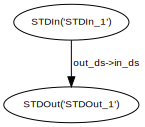

In [3]:
config = {'cores': 1, 'ram': 4096}
records = 100
size = '10MB'
ip_filename = "/data/sdk_testbench/input_data/file" + size + ".txt"
op_filename = "/data/sdk_testbench/output_data/tc_07.txt"

std_in = STDIn(records=records, filename=ip_filename)
std_in.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
std_in.out_ds = rf.Output.set(transport=rf.FileTransport)

std_out = STDOut(in_ds=std_in.out_ds, out_filename=op_filename)
std_out.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

pipeline = rf.Pipeline(name='series_file_transport', targets=[std_out])
pipeline.show()

In [4]:
def create_pipeline():
    return pipeline